In [7]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pyemma
import deeptime as dt
import mdtraj as md
import networkx as nx
from timescales import implied_timescales_msm
from copy import deepcopy
import nglview as nv
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine
from pathlib import Path
from sklearn.preprocessing import RobustScaler
import mdshare
from scipy.stats import binned_statistic_2d

In [8]:
fake_trj_fname = [str(p) for p in Path('ADP_cg2aa_hallucinate/').glob('aa_hallucinate_*')]
fake_top_fname = 'ADP_testset/AA.pdb'

# REAL

In [10]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='ref_ADP_data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='ref_ADP_data')
num_timescales=16
lagtime = 1

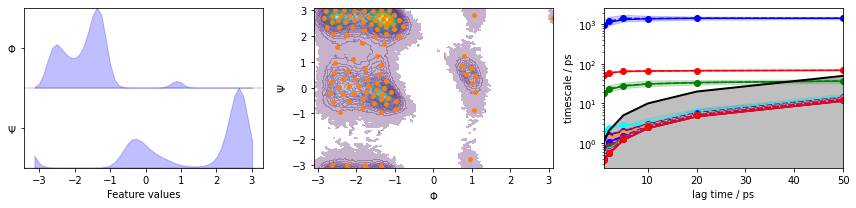

In [11]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

cluster = dt.clustering.KMeans(100, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


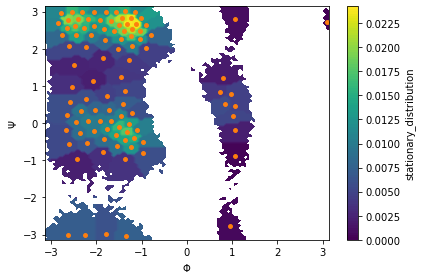

In [13]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[np.concatenate(dtrajs)],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999985443, max=1.0000000000001374)


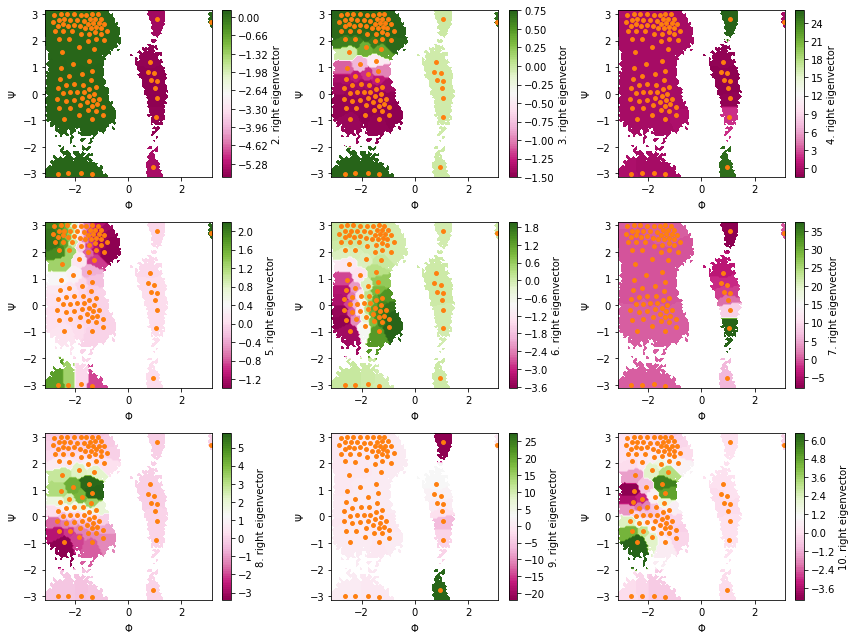

In [14]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[np.concatenate(dtrajs), i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

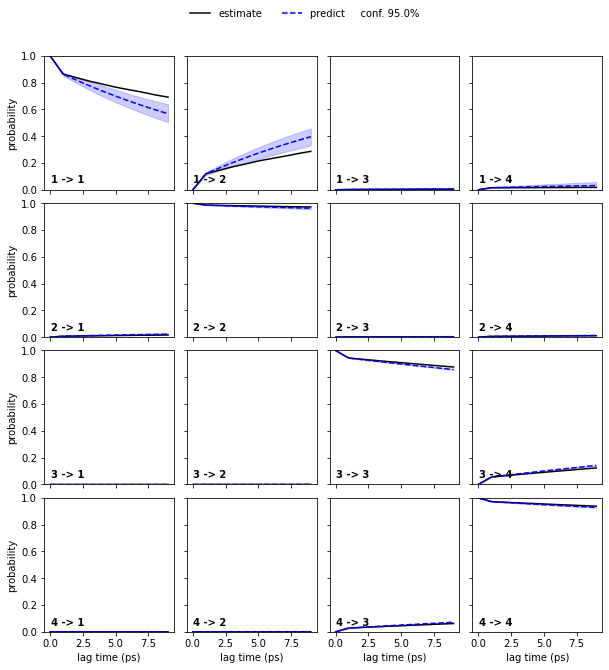

In [15]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [16]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
real_sample_mean = sample_mean
real_sample_conf_l = sample_conf_l
real_sample_conf_r = sample_conf_r

Mean of ITS #0: 992.737922
Confidence interval of ITS #0: [722.967553, 1384.077487]
Mean of ITS #1: 52.681978
Confidence interval of ITS #1: [51.431808, 53.921406]
Mean of ITS #2: 18.211143
Confidence interval of ITS #2: [13.348550, 23.498916]
Mean of ITS #3: 2.058110
Confidence interval of ITS #3: [2.042145, 2.071390]
Mean of ITS #4: 1.342178
Confidence interval of ITS #4: [1.328906, 1.359304]
Mean of ITS #5: 1.048769
Confidence interval of ITS #5: [0.996307, 1.169398]
Mean of ITS #6: 0.993797
Confidence interval of ITS #6: [0.956866, 1.007762]
Mean of ITS #7: 0.682085
Confidence interval of ITS #7: [0.649159, 0.757356]
Mean of ITS #8: 0.640955
Confidence interval of ITS #8: [0.577333, 0.662570]
Mean of ITS #9: 0.562472
Confidence interval of ITS #9: [0.556696, 0.567306]
Mean of ITS #10: 0.529640
Confidence interval of ITS #10: [0.491436, 0.558945]
Mean of ITS #11: 0.474452
Confidence interval of ITS #11: [0.469956, 0.478944]
Mean of ITS #12: 0.442544
Confidence interval of ITS #12: [

In [17]:
evec_real = eigvec
dtrajs_real = dtrajs
projected_data_real = projected_data

# Fake

In [18]:
pdb = fake_top_fname
files = fake_trj_fname

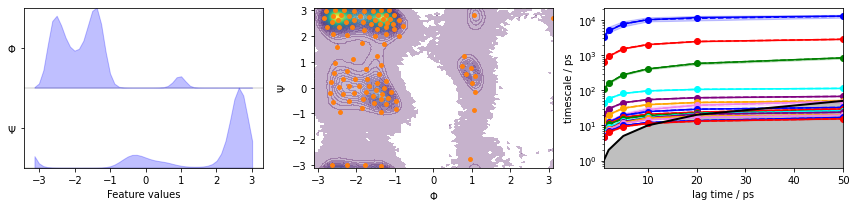

In [19]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

#cluster = dt.clustering.KMeans(100, max_iter=500).fit(np.concatenate(projected_data)).fetch_model()
dtrajs = [cluster.transform(traj) for traj in projected_data]

its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(np.concatenate(projected_data), 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*np.concatenate(projected_data).T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


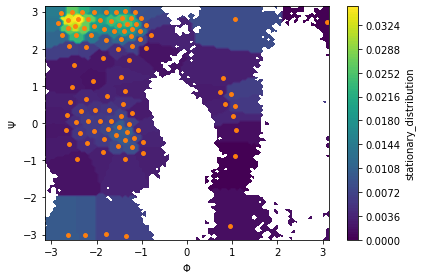

In [20]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *np.concatenate(projected_data).T, msm.stationary_distribution[np.concatenate(dtrajs)],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999933219, max=1.000000000007376)


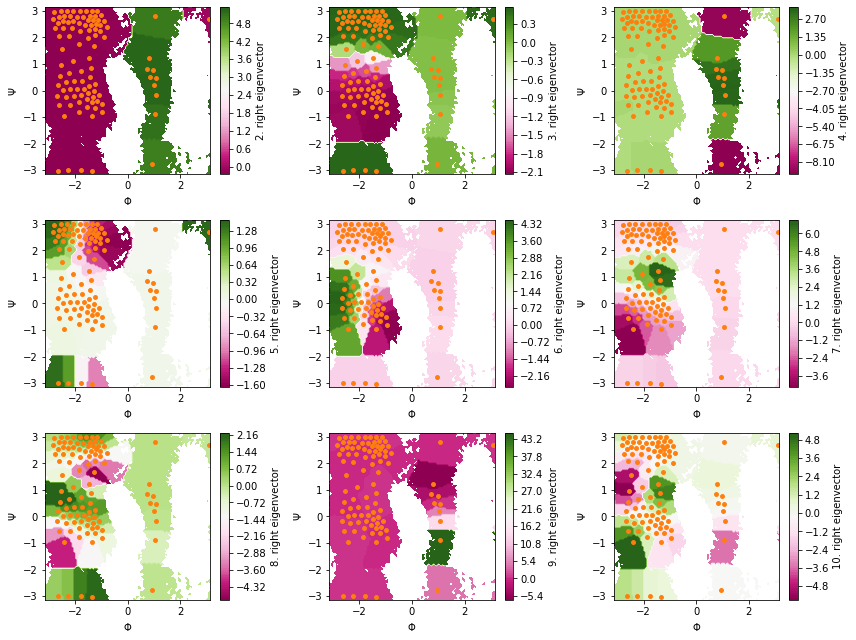

In [21]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.concatenate(projected_data).T, eigvec[np.concatenate(dtrajs), i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

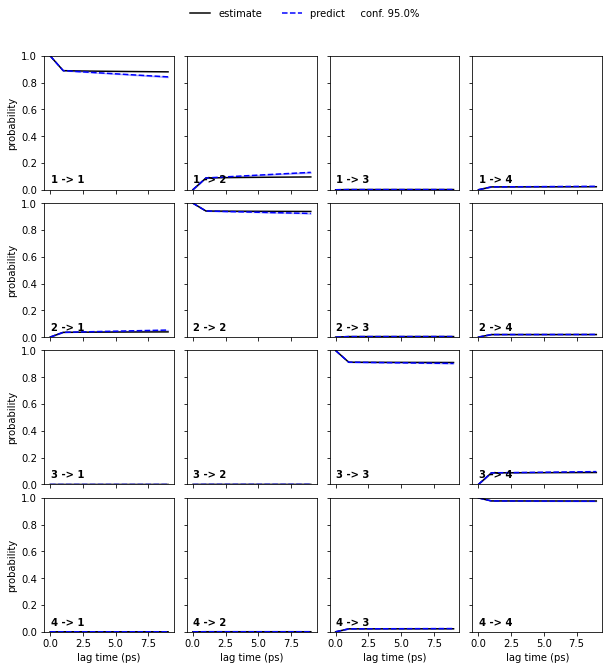

In [22]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [23]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
fake_sample_mean = sample_mean
fake_sample_conf_l = sample_conf_l
fake_sample_conf_r = sample_conf_r

Mean of ITS #0: 3239.649713
Confidence interval of ITS #0: [2649.235352, 3819.663871]
Mean of ITS #1: 622.325000
Confidence interval of ITS #1: [610.710604, 635.370834]
Mean of ITS #2: 105.435504
Confidence interval of ITS #2: [100.515511, 111.513135]
Mean of ITS #3: 42.034089
Confidence interval of ITS #3: [41.841359, 42.208306]
Mean of ITS #4: 20.970277
Confidence interval of ITS #4: [20.804138, 21.168892]
Mean of ITS #5: 13.768735
Confidence interval of ITS #5: [13.651137, 13.900804]
Mean of ITS #6: 9.013742
Confidence interval of ITS #6: [8.972684, 9.057306]
Mean of ITS #7: 8.191678
Confidence interval of ITS #7: [7.914318, 8.657316]
Mean of ITS #8: 7.892802
Confidence interval of ITS #8: [7.601970, 7.958519]
Mean of ITS #9: 7.474336
Confidence interval of ITS #9: [7.444572, 7.499868]
Mean of ITS #10: 6.455824
Confidence interval of ITS #10: [6.420313, 6.487037]
Mean of ITS #11: 5.735832
Confidence interval of ITS #11: [5.716779, 5.869416]
Mean of ITS #12: 5.570500
Confidence inter

In [24]:
evec_fake = eigvec
dtrajs_fake = dtrajs
projected_data_fake = projected_data

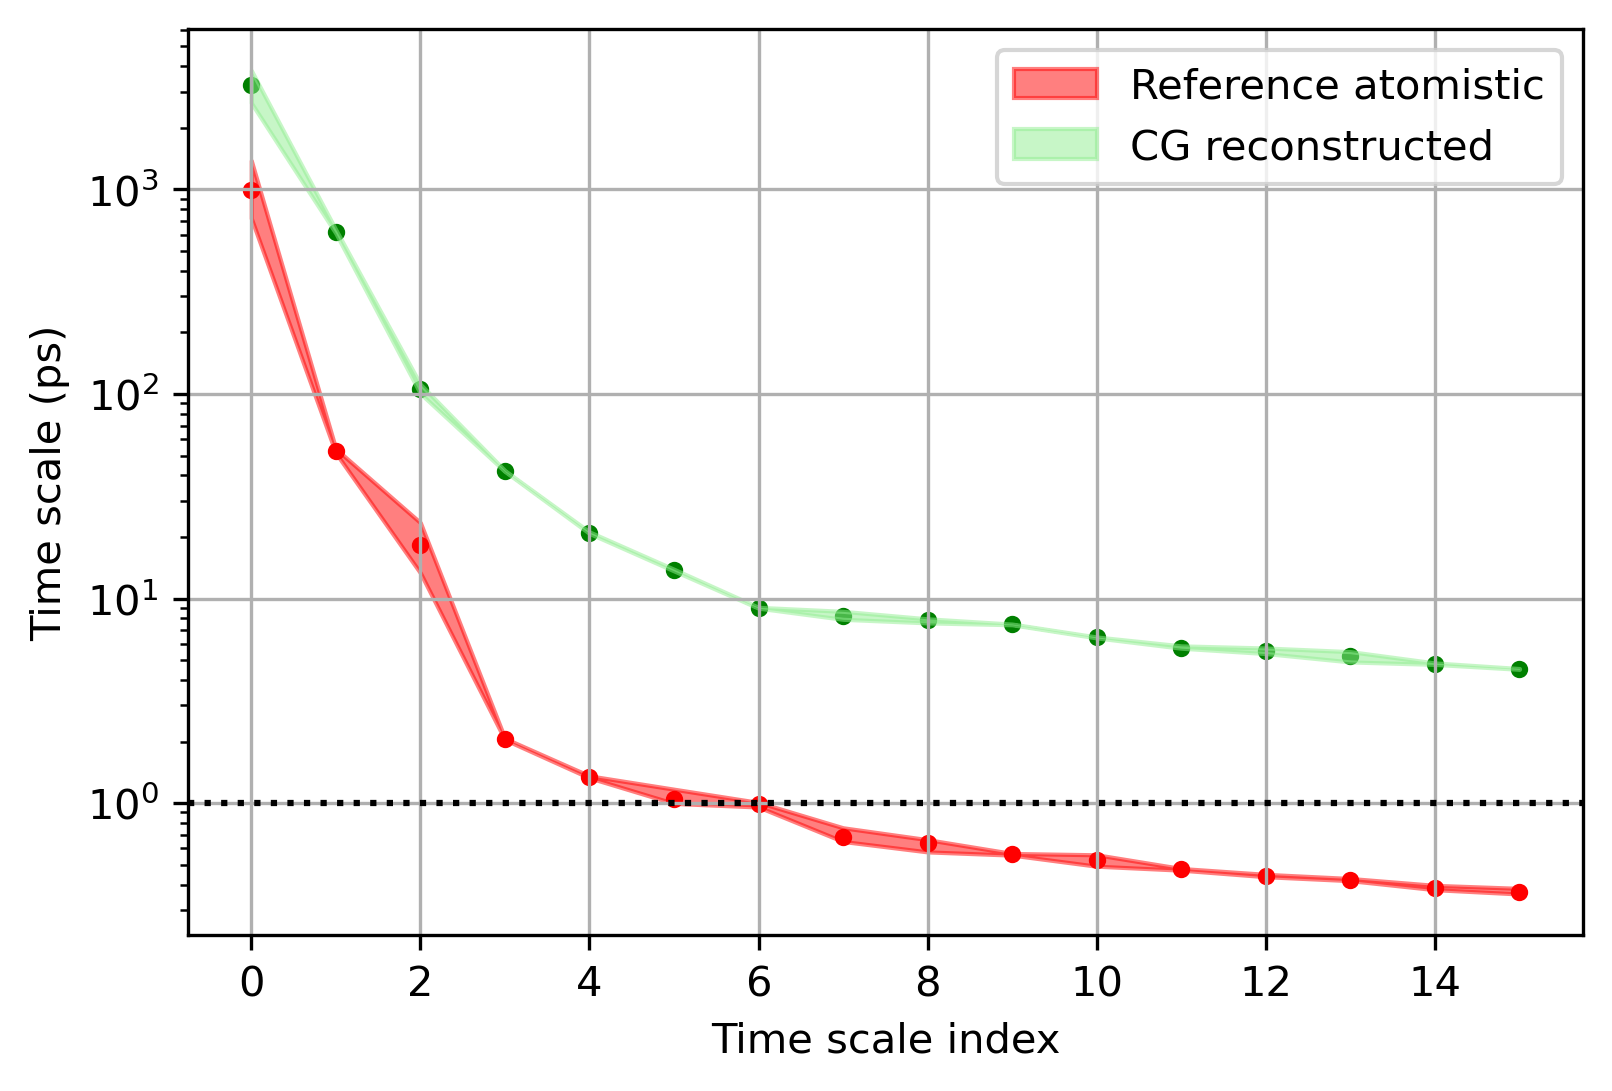

In [25]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Reference atomistic')
plt.yscale('log')

m = fake_sample_mean
r =  fake_sample_conf_r
l =  fake_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='CG reconstructed')
plt.yscale('log')

plt.axhline(1, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (ps)')
plt.show()

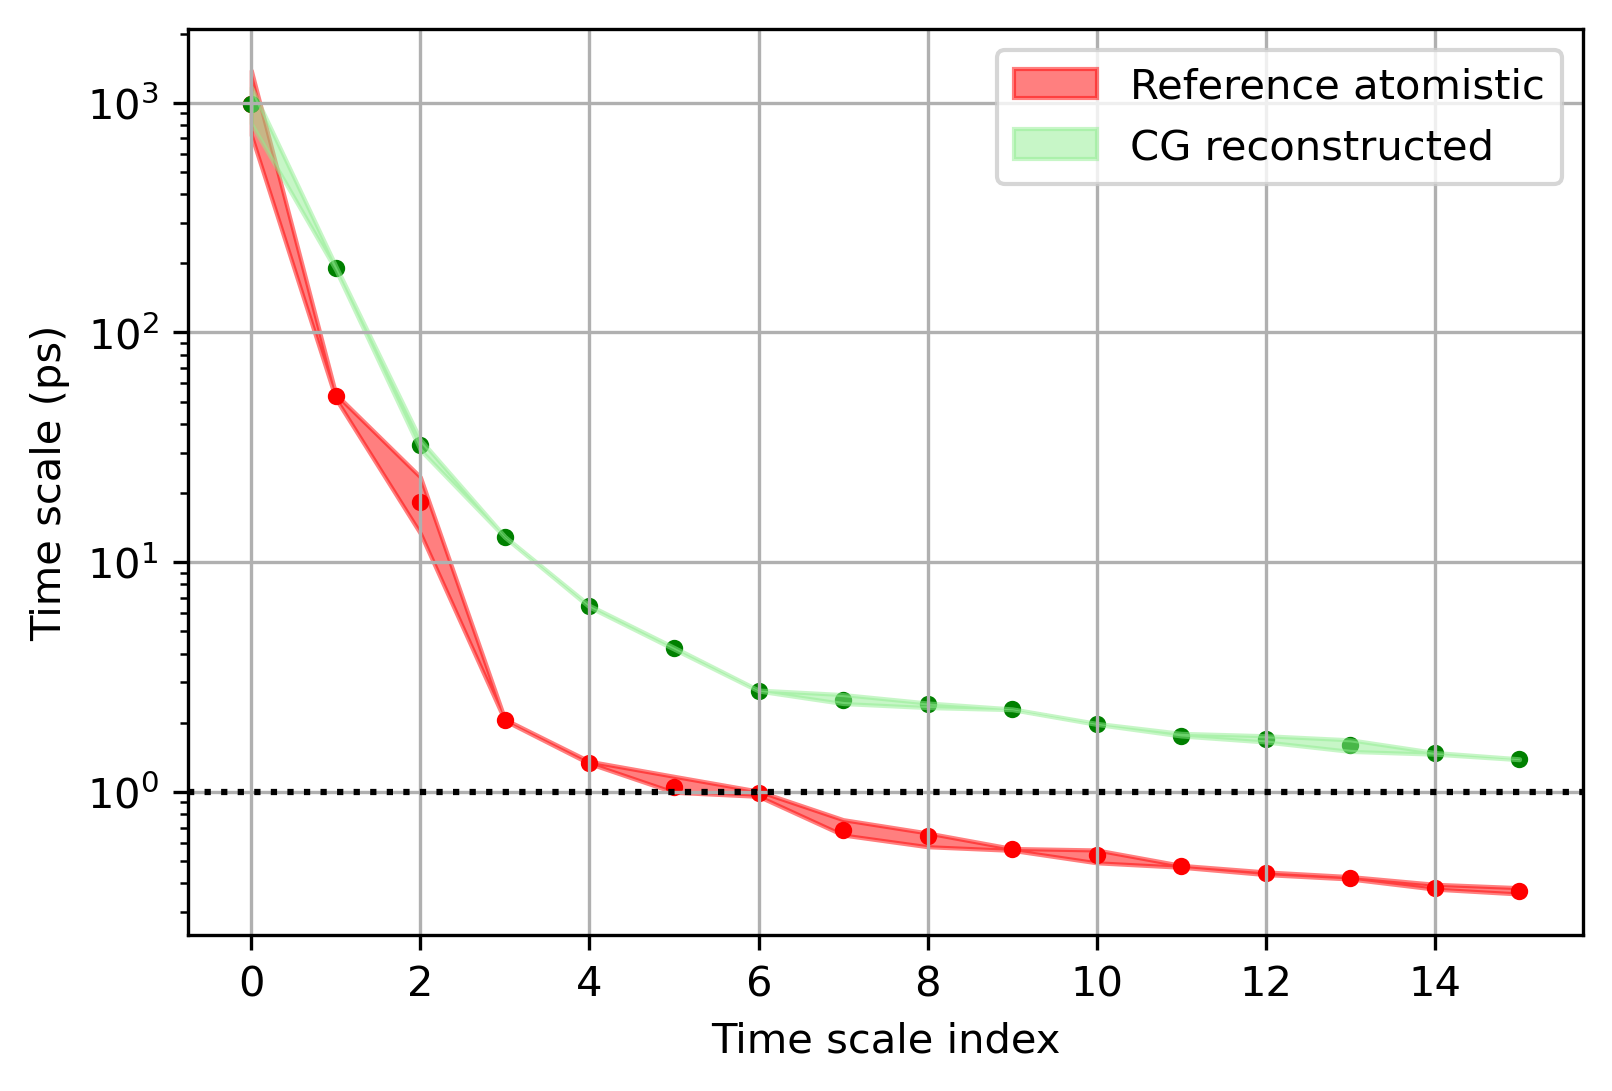

In [94]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

fac = real_sample_mean[0] / fake_sample_mean[0]

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Reference atomistic')
plt.yscale('log')

m = fake_sample_mean * fac
r =  fake_sample_conf_r * fac
l =  fake_sample_conf_l * fac

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='CG reconstructed')
plt.yscale('log')

plt.axhline(1, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (ps)')
plt.show()

In [26]:
evec_fake = eigvec
dtrajs_fake = dtrajs
projected_data_fake = projected_data

In [72]:
scores = list()
for ts in tqdm(range(1, num_timescales+1)):
    ev = evec_real[np.concatenate(dtrajs_real), ts][..., None]
    X = np.concatenate((np.concatenate(projected_data_real), ev), axis=-1)

    x = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
    y = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)

    ret_real = binned_statistic_2d(X[:, 0], X[:, 1], X[:, 2], statistic=np.mean, bins=[x, y])
    
    ev = evec_fake[np.concatenate(dtrajs_fake), ts][..., None]
    X = np.concatenate((np.concatenate(projected_data_fake), ev), axis=-1)

    ret_fake = binned_statistic_2d(X[:, 0], X[:, 1], X[:, 2], statistic=np.mean, bins=[x, y])
    
    mask_real = ~np.isnan(ret_real.statistic.flatten())
    mask_fake = ~np.isnan(ret_fake.statistic.flatten())
    mask = np.logical_and(mask_real, mask_fake)
    
    scores.append(abs(1 - cosine(ret_real.statistic.flatten()[mask], ret_fake.statistic.flatten()[mask])))

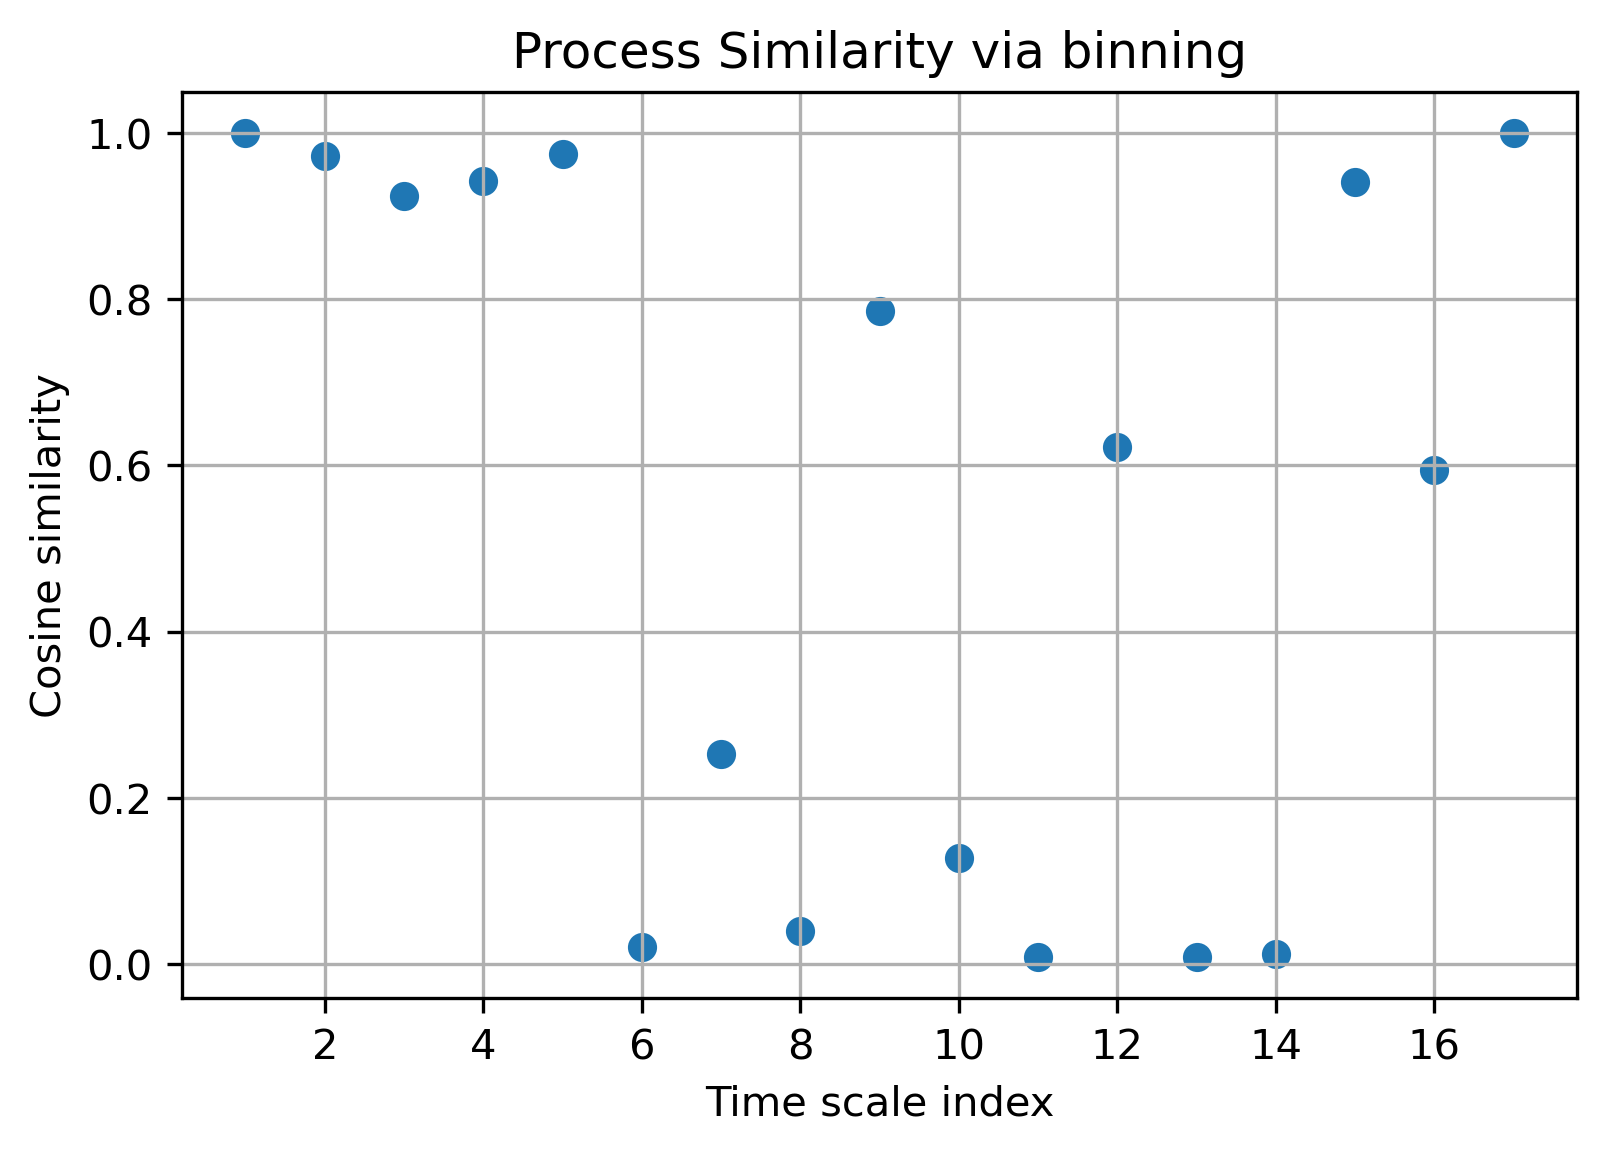

In [85]:
plt.figure(dpi=300)
plt.scatter(range(1, len(scores) + 1), scores)
plt.grid()
plt.xlabel('Time scale index')
plt.ylabel('Cosine similarity')
plt.title('Process Similarity via binning')
plt.show()

In [87]:
scores = list()
for ts in tqdm(range(1, num_timescales+1)):
    scores.append(abs(1 - cosine(evec_real[:, ts], evec_fake[:, ts])))    

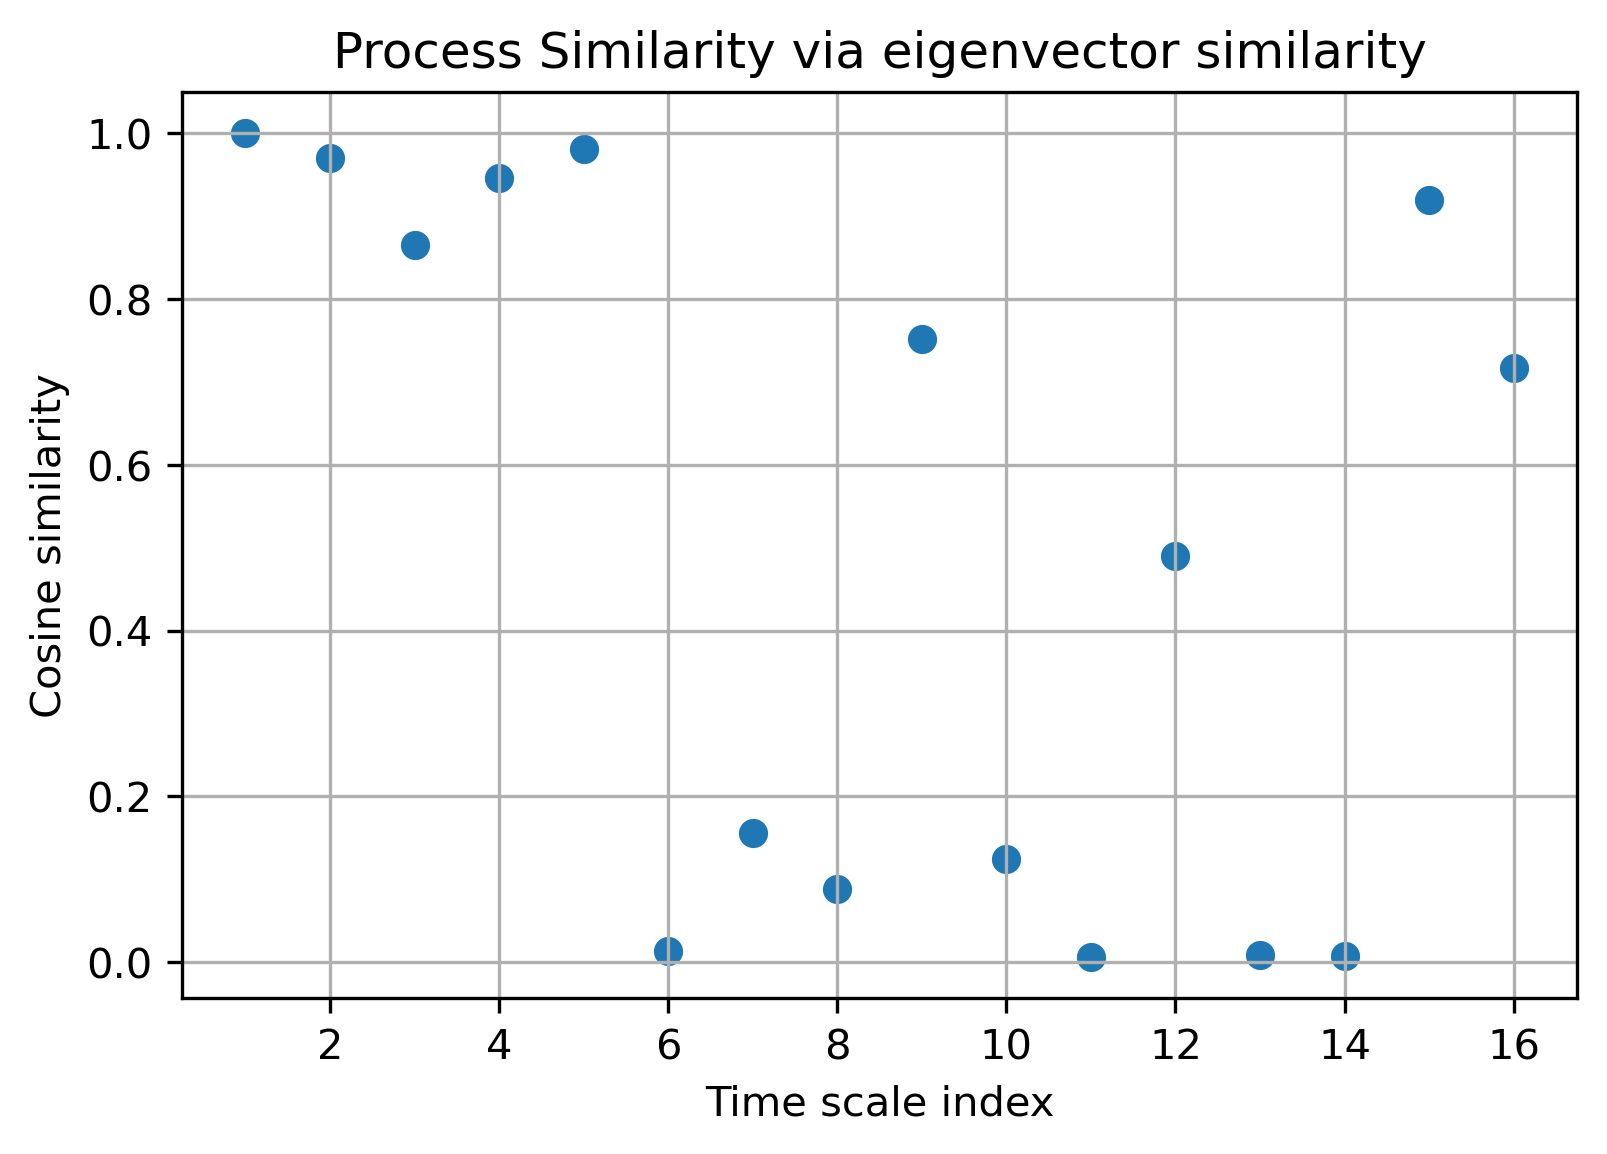

In [89]:
plt.figure(dpi=300)
plt.scatter(range(1, len(scores) + 1), scores)
plt.grid()
plt.xlabel('Time scale index')
plt.ylabel('Cosine similarity')
plt.title('Process Similarity via eigenvector similarity')
plt.show()